In [265]:
import json
import random
import numpy as np
import pandas as pd
from time import time
import sklearn
import seaborn as sn

In [266]:
with open("imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) #play it safe! (why?)
print("class label:", data[0]["class"])
print("text:",data[0]["text"])

class label: neg
text: In the first one it was mainly giant rats, but there were some wasps and a giant chicken too. This one, however, is just giant rats period, well giant rats and one really growing little boy. This one is about this growing boy and a scientist that is trying to help him so he accidentally creates giant killer rats...you know how it is. This movie has some kills and its moments, but I find it to be on par with the original, I just prefer some variety in my giant creature movies. Well, that is not true...I actually like \Empire of the Ants\", maybe I just do not care for giant rodents. All in all a rather drab movie though it does have one rather odd turn of events in this one dream sequence that is truly bizarre. I just can't recommend this one."


In [5]:
texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]

In [92]:
Counter(labels) # balanced number of labels

Counter({'neg': 12500, 'pos': 12500})

In [6]:
print("This many texts",len(texts))
print("This many labels",len(labels))
print()
for label,text in list(zip(labels,texts))[:20]:
    print(label,text[:50]+"...")

This many texts 25000
This many labels 25000

neg The premise is ridiculous, the characters unbeliev...
neg If you have seen very less films, this might be a ...
neg My title ought to be enough.  It baffles me that a...
pos i got to see the whole movie last night and i foun...
pos I watched this film so many times through my child...
neg This movie is not as horrible as most Sci-Fi Chann...
neg Having the In-Laws over for the weekend? Then this...
pos This is the moving tale of Scotland's legendary he...
pos Fabulous film! Rented the DVD recently and was flo...
pos Yes its an art... to successfully make a slow pace...
pos I have seen this movie and even though I kind of k...
pos As a convert into the Church of Jesus Christ of La...
neg Serge Farnel made a very precise critics of this f...
pos Well, when before I saw this film I really wasn't ...
neg Damn, I thought I'd seen some bad westerns. Can't ...
neg Zombie Nation 2004 R  Hey, I was bored. I looked i...
neg OK this movie was made

## 1.Test sklearn’s TfidfVectorizer in place of CountVectorizer on the IMDB data. Do you see any difference in the classification results or the optimal C value?

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(max_features=100000,binary=True,ngram_range=(1,1))
feature_matrix_count=vectorizer.fit_transform(texts)
print("shape=",feature_matrix_count.shape)
print("what did we get? ->", feature_matrix_count.__class__)

shape= (25000, 74849)
what did we get? -> <class 'scipy.sparse.csr.csr_matrix'>


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

def split_data_get_feature_matrix(text, labels, Vectorizer=CountVectorizer, ngram_range=(1, 1)):
    from sklearn.model_selection import train_test_split

    train_texts, dev_texts, train_labels, dev_labels=train_test_split(texts,labels,test_size=0.2)
    
    vectorizer=Vectorizer(max_features=100000,binary=True,ngram_range=ngram_range)
        
    feature_matrix_train=vectorizer.fit_transform(train_texts)
    feature_matrix_dev=vectorizer.transform(dev_texts)
    
    split_dict = {'train_texts': train_texts, 
                  'dev_texts': dev_texts, 
                  'train_labels':train_labels,
                  'dev_labels':dev_labels,
                  'feature_matrix_train':feature_matrix_train,
                  'feature_matrix_dev':feature_matrix_dev}
    
    return split_dict, vectorizer

In [9]:
def grid_searchSVC(X_train, y_train):
    from sklearn.svm import LinearSVC
    from sklearn.model_selection import GridSearchCV
    
    param_grid =  [{'C': [0.001, 0.01, 0.1, 1, 10, 120]}]        

    grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [10]:
def get_svm_results(split_dict, c=1):
    classifier=sklearn.svm.LinearSVC(C=c)
    classifier.fit(split_dict['feature_matrix_train'], split_dict['train_labels'])

    score_dev = classifier.score(split_dict['feature_matrix_dev'], split_dict['dev_labels'])
    return score_dev
    

#### Using CountVectorizer

In [11]:
split_count, vectorizer_count = split_data_get_feature_matrix(text, labels)
gcv_count = grid_searchSVC(split_count['feature_matrix_train'], split_count['train_labels'])
    

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [14]:
index = [gcv_count.cv_results_['params'].index({'C': 1})]
score_train = gcv_count.cv_results_['mean_test_score'][index]
score_dev = get_svm_results(split_count)

print(f'TRAIN: With default C = 1 accuracy was {score_train}')
print(f'DEV: With default C = 1 accuracy was {[score_dev]}')

TRAIN: With default C = 1 accuracy was [0.8578]
DEV: With default C = 1 accuracy was [0.8584]


In [15]:
best_C = gcv_count.best_params_['C']
acc = gcv_count.best_score_
score_dev = get_svm_results(split_count, c=best_C)
print(f'TRAIN: The best C parameter, based on gridsearch, was {best_C}, with an accuracy of {[acc]}')
print(f'DEV: The best C parameter, based on gridsearch, was {best_C}, with an accuracy of {[score_dev]}')

TRAIN: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.8799]
DEV: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.8788]


#### Using TfidfVectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
split_Tfidf,vectorizer_Tfidf  = split_data_get_feature_matrix(text, labels, Vectorizer=TfidfVectorizer)
gcv_Tfidf = grid_searchSVC(split_Tfidf['feature_matrix_train'], split_Tfidf['train_labels'])
    

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [17]:
index = [gcv_Tfidf.cv_results_['params'].index({'C': 1})]
score_train = gcv_Tfidf.cv_results_['mean_test_score'][index]
score_dev = get_svm_results(split_Tfidf)
print(f'TRAIN: With default C = 1 accuracy was {score_train}')
print(f'DEV: With default C = 1 accuracy was {[score_dev]}')

TRAIN: With default C = 1 accuracy was [0.8852]
DEV: With default C = 1 accuracy was [0.8924]


In [18]:
best_C = gcv_Tfidf.best_params_['C']
acc = gcv_Tfidf.best_score_
score_dev = get_svm_results(split_Tfidf, c=best_C)
print(f'TRAIN: The best C parameter, based on gridsearch, was {best_C}, with an accuracy of {[acc]}')
print(f'DEV: The best C parameter, based on gridsearch, was {best_C}, with an accuracy of {[score_dev]}')

TRAIN: The best C parameter, based on gridsearch, was 0.1, with an accuracy of [0.88645]
DEV: The best C parameter, based on gridsearch, was 0.1, with an accuracy of [0.8904]


## Answer:
Comparing CountVectorizer with TfidfVectorizer shows that, generally, TfidfVectorizer performed _marginally_ better. 

Further, it was shown that using preliminary optimal C values TfidfVectorizer had an optimal C of 1 and CountVectorizer had an optimal C of 0.01

## 2.Test different lengths of n-grams in the CountVectorizer on the IMDB data.Do you see any difference in the classification results or the optimal C value? Do these n-grams show up also in the list of most significant positive/negative features

In [27]:
def test_ranges(r):    
    split_count, vectorizer_count = split_data_get_feature_matrix(text, labels, ngram_range=r)
    gcv_count = grid_searchSVC(split_count['feature_matrix_train'], split_count['train_labels'])

    index = [gcv_count.cv_results_['params'].index({'C': 1})]
    score_train = gcv_count.cv_results_['mean_test_score'][index]
    score_dev = get_svm_results(split_count)
    print(f'RESULTS FOR NGRAM RANGE OF  {r}')
    print('Using default parameters (C=1):')
    print(f'(TRAIN) scores = {score_train}')
    print(f'(DEV) scores = {[score_dev]}')

    best_C = gcv_count.best_params_['C']
    acc = gcv_count.best_score_
    score_dev = get_svm_results(split_count, c=best_C)
    print(f'TRAIN: The best C parameter, based on gridsearch, was {best_C}, with an accuracy of {[acc]}')
    print(f'DEV: The best C parameter, based on gridsearch, was {best_C}, with an accuracy of {[score_dev]}')

    results_dict= {'split_count': split_count,
                    'vectorizer':vectorizer_count,
                    'gcv':gcv_count, 
                    'score_train': score_train,
                    'score_dev': score_dev,
                    'best_C': best_C,
                    'score_opt_train': acc,
                    'score_opt_dev': score_dev}
    print('\n\n')
    return results_dict

In [28]:
ngram_dict = {}
ranges = [(1, 1),
          (1, 2),
          (1, 3)]
for r in ranges:
    ngram_dict[r] = test_ranges(r)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RESULTS FOR NGRAM RANGE OF  (1, 1)
Using default parameters (C=1):
(TRAIN) scores = [0.8548]
(DEV) scores = [0.8696]
TRAIN: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.8782]
DEV: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.889]





/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RESULTS FOR NGRAM RANGE OF  (1, 2)
Using default parameters (C=1):
(TRAIN) scores = [0.8829]
(DEV) scores = [0.8808]
TRAIN: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.89045]
DEV: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.8906]





/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RESULTS FOR NGRAM RANGE OF  (1, 3)
Using default parameters (C=1):
(TRAIN) scores = [0.88325]
(DEV) scores = [0.8904]
TRAIN: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.89055]
DEV: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.8964]





#### Answer (Part1):
It seems that including bigrams (ngram=2) improves the performance, however, ngram=3 does not seem to add any additional improvements. Preliminary optimal C for all 3 were the same (C=0.01), however, one could (in principle) dive deeper and see if there are better optimal Cs and whether they deviate. For curiousity's sake I will test a few other ranges.

In [23]:
ranges = [(2, 2),
          (2, 3),
          (3, 3)]
for r in ranges:
    ngram_dict[r] = test_ranges(r)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RESULTS FOR NGRAM RANGE OF  (2, 2)
Using default parameters (C=1):
(TRAIN) scores = [0.86035]
(DEV) scores = [0.8586]
TRAIN: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.87145]
DEV: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.8712]





/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RESULTS FOR NGRAM RANGE OF  (2, 3)
Using default parameters (C=1):
(TRAIN) scores = [0.85865]
(DEV) scores = [0.8556]
TRAIN: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.8686]
DEV: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.8696]





/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RESULTS FOR NGRAM RANGE OF  (3, 3)
Using default parameters (C=1):
(TRAIN) scores = [0.8092]
(DEV) scores = [0.8086]
TRAIN: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.82685]
DEV: The best C parameter, based on gridsearch, was 0.01, with an accuracy of [0.8352]





As one would expect, not including single words (i.e. ranges from 2 and upwards) did not improve performance.

In [29]:
def feature_interpreter(ngram_dict_range):

    vectorizer = ngram_dict_range['vectorizer']
    gcv = ngram_dict_range['gcv']
    
    index2feature={}
    for feature,idx in vectorizer.vocabulary_.items():
        assert idx not in index2feature #This really should hold
        index2feature[idx]=feature

    indices=np.argsort(gcv.best_estimator_.coef_[0])
    print(indices)
    for idx in indices[:30]:
        print(index2feature[idx])
    print("-------------------------------")
    for idx in indices[::-1][:30]: #you can also do it the other way round, reverse, then pick
        print(index2feature[idx])

In [30]:
feature_interpreter(ngram_dict[(1, 3)])

[ 9898 12882 98243 ... 31886 61540 24846]
awful
boring
worst
poorly
disappointing
poor
waste
disappointment
dull
bad
unfortunately
terrible
lacks
mess
the worst
worse
lame
ridiculous
laughable
at best
stupid
not even
oh
the original
avoid
horrible
fails
annoying
wonder
not worth
-------------------------------
excellent
perfect
great
superb
today
enjoyable
amazing
wonderful
fantastic
rare
must see
simple
liked
10 10
enjoyed
at the end
loved
definitely worth
of what
noir
favorite
brilliant
fun
wonderfully
enjoyed it
bit
surprisingly
love this
well worth
fascinating


#### Answer (Part2):
As mentioned earlier including ngrams of 1 and 2 improved classifier performance and this is reflected in the classifier coefficients. 

For example 'definitely worth', 'enjoyed it' and 'must see' were flagged as important features for positive labels and 'the worst' and 'waste of' were considered flagged as important features for negative labels.

Considering that ngrams of 3 did not further improve classerier performance is reflected in the observation that none of the word triplets were flagged as important when including them.

## 3.In the data package for the course (http://dl.turkunlp.org/intro-to-nlp.tar.gz),the directory language_identification contains data for 5 languages. Based on this data, train an SVMclassifier for language recognition between these 5 language

In [31]:
!wget http://dl.turkunlp.org/intro-to-nlp.tar.gz
    
import tarfile
with tarfile.open('intro-to-nlp.tar.gz', 'r:gz') as t:
    t.extractall()


--2020-02-26 03:54:20--  http://dl.turkunlp.org/intro-to-nlp.tar.gz
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76192539 (73M) [application/octet-stream]
Saving to: ‘intro-to-nlp.tar.gz’

intro-to-nlp.tar.gz 100%[===================>]  72.66M   346MB/s    in 0.2s    

2020-02-26 03:54:20 (346 MB/s) - ‘intro-to-nlp.tar.gz’ saved [76192539/76192539]



In [32]:
from os import listdir
fnames = [f'intro-to-nlp/language-identification/{f}' for f in listdir('intro-to-nlp/language-identification/') if '.txt' in f]

In [144]:
from random import shuffle

data_dict = {'train':[], 'test':[], 'devel': []}
for file in fnames:
    
    with open(file, 'r') as f:
        text = f.read().split('\n')
    
    lang, sample = file.split('/')[-1].split('.')[0].split('_')
    
    for t in text:
        data_dict[sample].append([t, lang])
    
#for key in data_dict:
#    shuffle(data_dict[key])

train = np.array(data_dict['train'])[:, 0]
train_label = np.array(data_dict['train'])[:, 1]

test = np.array(data_dict['test'])[:, 0]
test_label = np.array(data_dict['test'])[:, 1]

dev = np.array(data_dict['devel'])[:, 0]
dev_label = np.array(data_dict['devel'])[:, 1]

In [136]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(max_features=100000,
                           binary=True,
                           ngram_range=(1,1),
                          analyzer='char')

fm_train=vectorizer.fit_transform(train)
fm_dev=vectorizer.transform(dev)
fm_test=vectorizer.transform(test)

In [137]:
def grid_searchSVC_multiclass(X_train, y_train):
    '''Have to use appropriate scoring for multiclass; I chose f1_macro
    - I could have modified the earlier one but decided to leave this one here for easier reviewing 
    '''
    from sklearn.svm import LinearSVC
    from sklearn.model_selection import GridSearchCV
    
    param_grid =  [{'C': [0.001, 0.01, 0.1, 1, 10, 120]}]   

    grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='f1_micro') 
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [138]:
gcv_multi = grid_searchSVC_multiclass(fm_train, train_label)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [139]:
print(f'Best Score: {gcv_multi.best_score_}')
print(f'Best Params: {gcv_multi.best_params_}')

Best Score: 0.9066933066933067
Best Params: {'C': 10}


In [140]:
from sklearn.metrics import f1_score

In [141]:
f1_score(gcv_multi.predict(fm_dev), dev_label, average='micro')

0.8999000999000999

In [142]:
f1_score(gcv_multi.predict(fm_test), test_label, average='micro')

0.9026973026973028

# 4. If you completed (3),toy around with features, especially the ngram_range and analyzer parameters, which allow you to test classification based on character ngrams of various lengths (not only word n-grams). Gain some in sight in to the accuracy of the classifier with different features, and try to identify misclassified documents-why do you think they were misclassified?

In [145]:
def language_features(train, dev, test, ngram_range=(1, 1), analyzer='char'):
    from sklearn.feature_extraction.text import CountVectorizer

    vectorizer=CountVectorizer(max_features=100000,
                               binary=True,
                               ngram_range=ngram_range,
                              analyzer='char')

    fm_train=vectorizer.fit_transform(train)
    fm_dev=vectorizer.transform(dev)
    fm_test=vectorizer.transform(test)
    
    return fm_train, fm_dev, fm_test

In [147]:
#maxRange = 6
#ranges = []
#for x in range(1, maxRange):
#    for y in range(x, maxRange):
#        ranges.append((x, y))

ranges = [(1, 1), (1, 2),(2, 2), (1, 3), (2, 3)]

for r in ranges:    
    fm_train, fm_dev, fm_test = language_features(train, dev, test, ngram_range=r) 
    
    gcv_multi = grid_searchSVC_multiclass(fm_train, train_label)
        
    score_dev = f1_score(gcv_multi.predict(fm_dev), dev_label, average='micro')
    score_test = f1_score(gcv_multi.predict(fm_test), test_label, average='micro')

    print(f'For range {r}')
    print(f'Best Params: {gcv_multi.best_params_}')
    print(f'Train Scores = {gcv_multi.best_score_}')
    print(f'DEV scores = {score_dev}')
    print(f'TEST scores = {score_test}')        
    print('')

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


For range (1, 1)
Best Params: {'C': 10}
Train Scores = 0.9066933066933067
DEV scores = 0.9018543606721238
TEST scores = 0.9020641434044983



/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


For range (1, 2)
Best Params: {'C': 0.01}
Train Scores = 0.9758241758241758
DEV scores = 0.9728781264094792
TEST scores = 0.9768701639528132



/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


For range (1, 3)
Best Params: {'C': 0.01}
Train Scores = 0.9778221778221778
DEV scores = 0.9756938867058451
TEST scores = 0.9798723820168679



/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


For range (2, 3)
Best Params: {'C': 0.01}
Train Scores = 0.9760239760239761
DEV scores = 0.9737401355284158
TEST scores = 0.975535589576533



In [148]:
r = (2, 2)
fm_train, fm_dev, fm_test = language_features(train, dev, test, ngram_range=r) 
    
gcv_multi = grid_searchSVC_multiclass(fm_train, train_label)

score_dev = f1_score(gcv_multi.predict(fm_dev), dev_label, average='micro')
score_test = f1_score(gcv_multi.predict(fm_test), test_label, average='micro')

print(f'For range {r}')
print(f'Best Params: {gcv_multi.best_params_}')
print(f'Train Scores = {gcv_multi.best_score_}')
print(f'DEV scores = {score_dev}')
print(f'TEST scores = {score_test}')        
print('')

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


For range (2, 2)
Best Params: {'C': 0.01}
Train Scores = 0.9734265734265735
DEV scores = 0.9692307692307692
TEST scores = 0.9706293706293706



In [153]:
r = (1, 2)
fm_train, fm_dev, fm_test = language_features(train, dev, test, ngram_range=r) 
    
gcv_multi = grid_searchSVC_multiclass(fm_train, train_label)

score_dev = f1_score(gcv_multi.predict(fm_dev), dev_label, average='micro')
score_test = f1_score(gcv_multi.predict(fm_test), test_label, average='micro')

print(f'For range {r}')
print(f'Best Params: {gcv_multi.best_params_}')
print(f'Train Scores = {gcv_multi.best_score_}')
print(f'DEV scores = {score_dev}')
print(f'TEST scores = {score_test}')        
print('')

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


For range (1, 2)
Best Params: {'C': 0.01}
Train Scores = 0.9758241758241758
DEV scores = 0.974025974025974
TEST scores = 0.9744255744255744



In [170]:
pred = gcv_multi.predict(fm_test)

In [171]:
a = pred==test_label

In [210]:
compare, lengths,  = [], [] 
langs_Y = []
langs_y = []
for x, y, z in zip(pred[a==False], test_label[a==False], test[a==False]):
    compare.append("{} vs {} errors".format(*sorted([x, y])))
    lengths.append(len(z))
    langs_Y.append(y)
    langs_y.append(x)
    print(f"True label: {y}, predicted label: {x}")
    print(f"{z}")
    print()
tot_lengths = [len(x) for x in test]

True label: pt, predicted label: et
Nada mais!

True label: pt, predicted label: en
Artes Plásticas

True label: pt, predicted label: en
The Washington Post

True label: pt, predicted label: es
Tudo, claro está, muito arborizado.

True label: pt, predicted label: es
E o volume de alumínio daria para fazer 275 mil latas de refrigerante.

True label: pt, predicted label: en
Com Jeff Goldblum, Alan Bates, Kathy Baker e Jean-Pierre Cassel

True label: pt, predicted label: en
Para melhor cantor, figuram José Carreras, Thomas Hampson, Ben Heppner, Sergei Leiferkus e Bryn Terfei.

True label: pt, predicted label: et
E ele gostava de Roosevelt e detestava os nazistas.

True label: pt, predicted label: et
MONTE ESTORIL

True label: pt, predicted label: fi
Fantasia infantil:

True label: pt, predicted label: en
Choque frontal

True label: pt, predicted label: es
LUIZ FELIPE DE ALENCASTRO, 48, historiador, é pesquisador de o Cebrap( Centro Brasileiro de Análise e Planejamento) e professor de o In

By eye-balling some of the wrongly predicted labels:

Some of the incorrectly predicted labels are a bit disappointing. However some are understandable. The Washington Post is the name of a newspaper and had the label for Portugues, but English was predicted. The same when using actor names in portuguese and predicting English etc.

In [208]:
Counter(compare)

Counter({'et vs pt errors': 9,
         'en vs pt errors': 16,
         'es vs pt errors': 14,
         'fi vs pt errors': 3,
         'en vs es errors': 12,
         'es vs et errors': 4,
         'et vs fi errors': 31,
         'en vs fi errors': 14,
         'en vs et errors': 25})

In [214]:
print('orignal label count')
Counter(langs_Y)

orignal label count


Counter({'pt': 27, 'es': 18, 'fi': 37, 'en': 26, 'et': 20})

In [213]:
print()
print('False label count')
Counter(langs_y)


False label count


Counter({'et': 49, 'en': 41, 'es': 12, 'fi': 11, 'pt': 15})

It seems that English, Finnish and Estonian were often involved in mislabelling. It seems that when it comes to Finnish and Estonian there were frequent mislabelling associated between the two. As for English the language was involved in many errors but the trend seems to be more wide spread among the languages. 

Which makes sense linguistically, although I would have thought Spanish and Portuguese would have been mixed up more frequently. 

Finnish and Estonian have certain unique orthographical properties (double vowels 'aa' for example, lower frequency use of 'd', 'g', 'c' etc). English has historically been influenced many languages and Estonian and Finnish are a bit different.

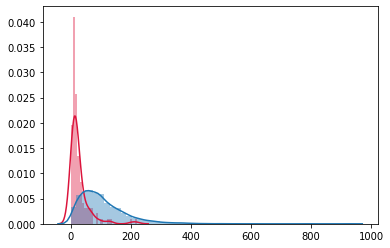

In [215]:
sn.distplot(lengths, color='crimson')
sn.distplot(tot_lengths)

Further, it seems that short sentences were more likely to be mislabelled than longer ones. The above graph shows the distribution of lengths for the test set in BLUE and and the mislabeled test set in RED.

### 5. Pick one language that interests you, and one treebank for that language ,and try to build a POS tagger for this language. what the state of the art roughly is for your selected language and treebank. Did you come close?


In [4]:
from os import listdir
fnames = [f for f in listdir() if '.conllu' in f]

In [161]:
corpus_dict = {}
for file in fnames:
    with open(file, 'r') as f:
        data = f.read().split('sent_id')

In [252]:
def prep_sen_data(file):
    
    with open(file, 'r') as f:
        data = f.read().split('# sent_id')
        
    current_sentence = []
    sentences = []
    OneWord=namedtuple("OneWord",["word", "pos_label"])
    for s in data:
        if s:
            lines = s.split('\n') 
            i = lines.index('')
            for l in lines[:i]:
                if '#' in l:
                    if current_sentence:
                        sentences.append(current_sentence)
                        current_sentence=[]
                        pos = 0
                    else:
                        continue
                #columns = l[1], l.split()[3],l.split()[4]
                if l[0].isdigit():
                    columns = [l.split()[1], l.split()[3]]
                    current_sentence.append(OneWord(*columns))
    return sentences




In [256]:
fnames

['af_afribooms-ud-test.conllu',
 'af_afribooms-ud-train.conllu',
 'af_afribooms-ud-dev.conllu']

In [257]:
sentences_train=list(prep_sen_data("af_afribooms-ud-train.conllu"))
sentences_dev=list(prep_sen_data("af_afribooms-ud-dev.conllu"))

In [258]:
len(sentences_train), len(sentences_dev)

(1314, 193)

In [259]:
def generate_sentence_features(sent):
    #Given a sentence as a list of (word, label) pairs
    #generate the features for every word
    #The result should be a list of same length as the sentence
    #Each item is a dictionary of {"feature name"->feature value} mappings, holding all features of the word at that position
    
    sent_features=[] #this will be the result
    for one_word in sent:
        #We do nothing with label
        #it just happens to be around
        word_features={}
        word_features["word_"+one_word.word]=1 #the word itself is a feature
        sent_features.append(word_features)
    return sent_features

print(generate_sentence_features(sentences_dev[0])  )

[{'word_En': 1}, {'word_ons': 1}, {'word_hoop': 1}, {'word_hierdie': 1}, {'word_keer': 1}, {'word_dat': 1}, {'word_hernude': 1}, {'word_pogings': 1}, {'word_deur': 1}, {'word_die': 1}, {'word_internasionale': 1}, {'word_gemeenskap': 1}, {'word_om': 1}, {'word_blywende': 1}, {'word_oplossings': 1}, {'word_vir': 1}, {'word_hierdie': 1}, {'word_konflik': 1}, {'word_te': 1}, {'word_vind': 1}, {'word_,': 1}, {'word_vrugte': 1}, {'word_sal': 1}, {'word_afwerp': 1}, {'word_sodat': 1}, {'word_die': 1}, {'word_Israeliete': 1}, {'word_en': 1}, {'word_die': 1}, {'word_Palestyne': 1}, {'word_as': 1}, {'word_bure': 1}, {'word_vrede': 1}, {'word_en': 1}, {'word_sekuriteit': 1}, {'word_kan': 1}, {'word_geniet': 1}, {'word_binne': 1}, {'word_hul': 1}, {'word_soewereine': 1}, {'word_gebiede': 1}, {'word_.': 1}]


In [260]:
#...now we can generate the training examples
def prep_data(sentences):
    all_labels=[] #here we gather labels for all words in all sentences
    all_features=[] #here we gather features for all words in all sentences
    for sentence in sentences:
        sent_features=generate_sentence_features(sentence)
        assert len(sent_features)==len(sentence)
        #Now we can get, for every position its label and its features
        for one_word,features in zip(sentence,sent_features):
            all_labels.append(one_word.pos_label) #label
            all_features.append(features)         #and features to go with it
    return all_labels, all_features

train_labels,train_features=prep_data(sentences_train)
dev_labels,dev_features=prep_data(sentences_dev)

In [261]:
from sklearn.feature_extraction import DictVectorizer
vectorizer=DictVectorizer()
vectorizer.fit(train_features)
print("Vectorizer vocab size:",len(vectorizer.vocabulary_))

feature_vectors_train=vectorizer.transform(train_features)
feature_vectors_dev=vectorizer.transform(dev_features)

print("Train shape",feature_vectors_train.shape)
print("Dev shape",feature_vectors_dev.shape)

Vectorizer vocab size: 5079
Train shape (33889, 5079)
Dev shape (5305, 5079)


In [262]:

import sklearn.svm

classifier=sklearn.svm.LinearSVC(C=0.05,verbose=1)
classifier.fit(feature_vectors_train, train_labels)

[LibLinear]

LinearSVC(C=0.05, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [263]:
classifier.score(feature_vectors_dev,dev_labels)

0.8452403393025447

In [264]:
def generate_sentence_features(sent):
    #Given a sentence as a list of (word, label) pairs
    #generate the features for every word
    #The result should be a list of same length as the sentence
    #Each item is a dictionary of {"feature name"->feature value} mappings, holding all features of the word at that position
    
    sent_features=[] #this will be the result
    for word_idx, one_word in enumerate(sent):
        #We do nothing with label
        #it just happens to be around
        word_features={}
        word_features["word_"+one_word.word]=1 #the word itself is a feature
        if word_idx!=0:
            word_features["left_word_"+sent[word_idx-1].word]=1
        if word_idx!=len(sent)-1:
            word_features["right_word_"+sent[word_idx+1].word]=1
        sent_features.append(word_features)
    return sent_features

train_labels,train_features=prep_data(sentences_train)
dev_labels,dev_features=prep_data(sentences_dev)
vectorizer=DictVectorizer()
vectorizer.fit(train_features)
feature_vectors_train=vectorizer.transform(train_features)
feature_vectors_dev=vectorizer.transform(dev_features)

print("Train shape",feature_vectors_train.shape)
print("Dev shape",feature_vectors_dev.shape)

classifier=sklearn.svm.LinearSVC(C=1,verbose=1)
classifier.fit(feature_vectors_train, train_labels)
classifier.score(feature_vectors_dev,dev_labels)

Train shape (33889, 14981)
Dev shape (5305, 14981)
[LibLinear]

0.9236569274269557

This is suspicious,  the highest performance according to the website is 97.82% for africaans.

1. UDPipe Future (Praha)                   	software1-P	97.82

At first I achieved 84.52%, which is not terrible. However, with the latter pipeline I acheived 92.37% which is better. To only be 5% off the best performance is nice, it is reasonably close for a first attempt :) 

I will continue to see if I can close that gap.